In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
import random

import warnings 
warnings.filterwarnings('ignore')

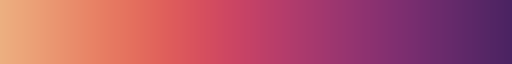

In [2]:
random.seed(42)
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
sns.color_palette("flare", as_cmap=True)

# Loding Data

In [9]:

dataframe = pd.read_feather('../input/amexfeather/train_data.ftr')
dataframe = dataframe.groupby('customer_ID').tail(1).set_index('customer_ID')


# Missing values

In [10]:
null_vals = dataframe.isna().sum().sort_values(ascending=False)
null_vals[null_vals > 0 ]

D_87     458268
D_88     458086
D_108    456286
D_110    455235
D_111    455235
          ...  
B_33         31
B_22         31
B_16         31
B_20         31
D_112        31
Length: 108, dtype: int64

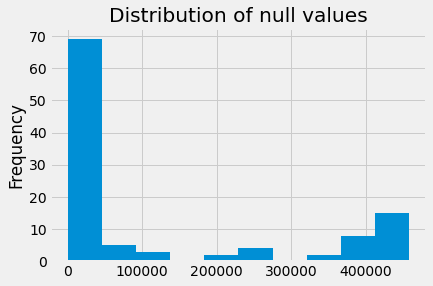

In [11]:
plt.title("Distribution of null values")
null_vals[null_vals > 0 ].plot(kind = 'hist');

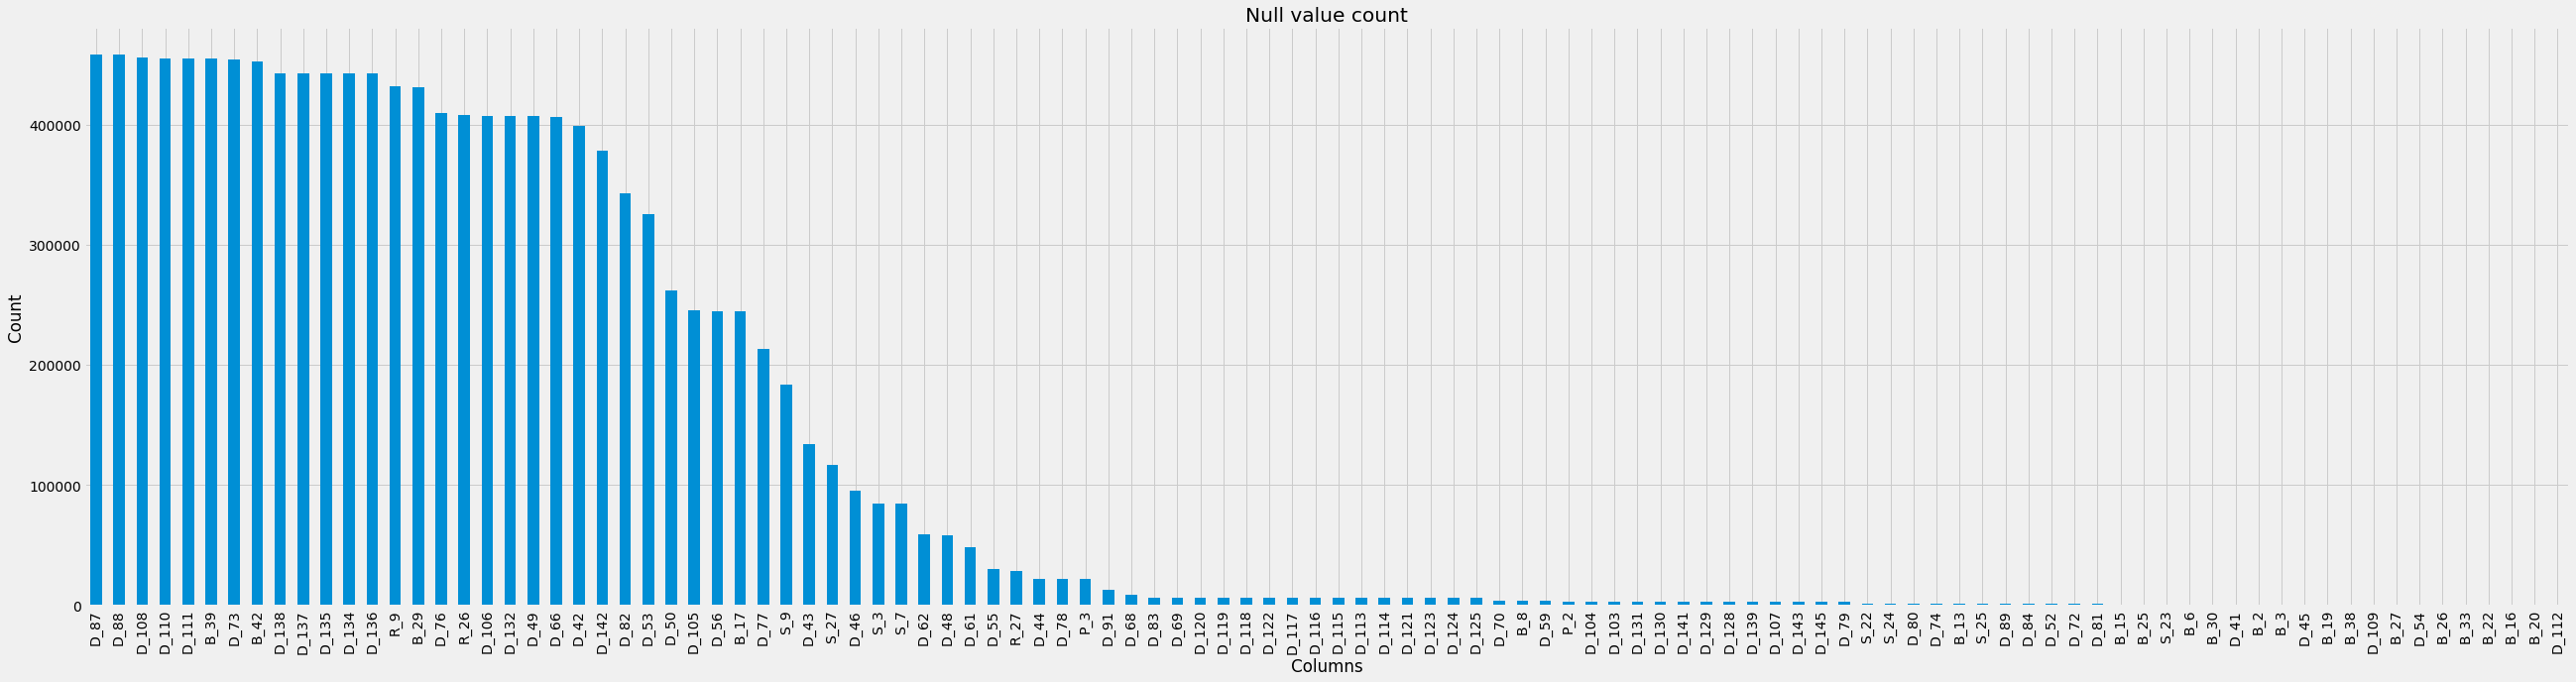

In [12]:
plt.figure(figsize=(40,10))
plt.title("Null value count")
plt.xlabel("Columns")
plt.ylabel("Count")
null_vals[null_vals > 0 ].plot(kind="bar");

# Target Imbalance

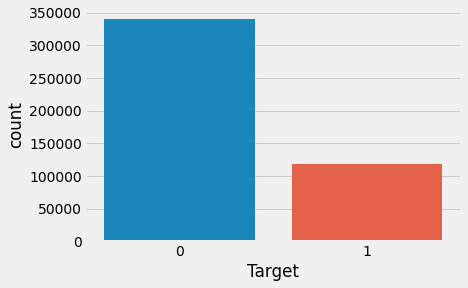

In [13]:
sns.countplot(
    dataframe["target"].values,
).set_xlabel("Target");

In [14]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers


In [23]:
#fix the variable later
#change to timestamp
dataframe = dataframe.drop('S_2',axis = 1)

KeyError: "['S_2'] not found in axis"

In [16]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 367130 samples for training and 91783 for validation


In [17]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

2022-08-18 16:46:07.194069: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [18]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)


2022-08-18 16:46:18.152469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 116424 of 367130
2022-08-18 16:46:28.152497: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 217267 of 367130
2022-08-18 16:46:38.152450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 313982 of 367130
2022-08-18 16:46:43.627610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


Input: {'P_2': <tf.Tensor: shape=(), dtype=float16, numpy=0.9106>, 'D_39': <tf.Tensor: shape=(), dtype=float16, numpy=0.589>, 'B_1': <tf.Tensor: shape=(), dtype=float16, numpy=0.2278>, 'B_2': <tf.Tensor: shape=(), dtype=float16, numpy=0.3206>, 'R_1': <tf.Tensor: shape=(), dtype=float16, numpy=0.00908>, 'S_3': <tf.Tensor: shape=(), dtype=float16, numpy=0.1114>, 'D_41': <tf.Tensor: shape=(), dtype=float16, numpy=0.00244>, 'B_3': <tf.Tensor: shape=(), dtype=float16, numpy=0.0344>, 'D_42': <tf.Tensor: shape=(), dtype=float16, numpy=nan>, 'D_43': <tf.Tensor: shape=(), dtype=float16, numpy=0.00572>, 'D_44': <tf.Tensor: shape=(), dtype=float16, numpy=0.007324>, 'B_4': <tf.Tensor: shape=(), dtype=float16, numpy=0.2008>, 'D_45': <tf.Tensor: shape=(), dtype=float16, numpy=0.3499>, 'B_5': <tf.Tensor: shape=(), dtype=float16, numpy=0.027>, 'R_2': <tf.Tensor: shape=(), dtype=float16, numpy=0.00297>, 'D_46': <tf.Tensor: shape=(), dtype=float16, numpy=0.5796>, 'D_47': <tf.Tensor: shape=(), dtype=floa

In [19]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)


In [20]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


In [35]:
imputs = dataframe.columns.tolist()

#with the following features being categorical:

categoricals  = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

#list of all numerical 

#apparently there is no simpler sinthax to remove list of elements from a list

numericals = [x for x in imputs if x not in categoricals]


# Build a model


In [ ]:
# Categorical features encoded as integers

VAR = keras.Input(shape=(1,), name="VAR", dtype="int64")

# Integer categorical features
VAR_ENCODED = encode_categorical_feature(VAR, "VAR", train_ds, False)

In [ ]:
var_encoded = {}

for vari in numericals:
	var_encoded[vari] = encode_numerical_feature(vari[''], vari, train_ds)
	
	
	
	
	
	all_features = layers.concatenate(var_encoded);
   
)

In [22]:


# Categorical features encoded as integers
VAR = keras.Input(shape=(1,), name="VAR", dtype="int64")


# Categorical feature encoded as string
VAR = keras.Input(shape=(1,), name="VAR", dtype="string")

# Numerical features
age = keras.Input(shape=(1,), name="age")


#all_inputs = [list oof]

# Integer categorical features
sex_encoded = encode_categorical_feature(sex, "sex", train_ds, False)


# String categorical features
thal_encoded = encode_categorical_feature(thal, "thal", train_ds, True)

# Numerical features
age_encoded = encode_numerical_feature(age, "age", train_ds)


all_features = layers.concatenate(
    [
        sex_encoded,
        cp_encoded,
        fbs_encoded,
        restecg_encoded,
        exang_encoded,
        slope_encoded,
        ca_encoded,
        thal_encoded,
        age_encoded,
        trestbps_encoded,
        chol_encoded,
        thalach_encoded,
        oldpeak_encoded,
    ]
)
x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

KeyError: in user code:

    /tmp/ipykernel_17/1989868597.py:28 None  *
        lambda x, y: x[name])

    KeyError: 'sex'


In [ ]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
model.fit(train_ds, epochs=50, validation_data=val_ds)

In [ ]:
#inference exampple

sample = {
    "age": 60,
    "sex": 1,
    "cp": 1,
    "trestbps": 145,
    "chol": 233,
    "fbs": 1,
    "restecg": 2,
    "thalach": 150,
    "exang": 0,
    "oldpeak": 2.3,
    "slope": 3,
    "ca": 0,
    "thal": "fixed",
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    "This particular patient had a %.1f percent probability "
    "of having a heart disease, as evaluated by our model." % (100 * predictions[0][0],)
)

# Submissions

Fit Submission to model



In [ ]:
submit = pd.read_csv('../input/amex-default-prediction/sample_submission.csv')
submit['prediction'] = 0

for df in dfs:
    submit['prediction'] += df['prediction']
    
submit['prediction'] /= 4

submit.to_csv('mean_submission.csv', index=None)


submit = pd.read_csv('../input/amex-default-prediction/sample_submission.csv')
submit['prediction'] = 0

for df in dfs:
    submit['prediction'] += rankdata(df['prediction'])/df.shape[0]
    
submit['prediction'] /= 4

submit.to_csv('rank_submission.csv', index=None)


In [ ]:
submit

In [ ]:
submit.describe()

In [ ]:
submit.plot()

In [ ]:
weights = [0.52, 0.87, 0.95, 0.57, 1, 0.8]

In [ ]:
submit = pd.read_csv('../input/amex-default-prediction/sample_submission.csv')
submit['prediction'] = 0

for df, weight in zip(dfs, weights):
    submit['prediction'] += (df['prediction'] * weight)
    
submit['prediction'] /= np.sum(weights)

submit.to_csv('mean_submission.csv', index=None)

 
submit = pd.read_csv('../input/amex-default-prediction/sample_submission.csv')
submit['prediction'] = 0

for df, weight in zip(dfs, weights):
    submit['prediction'] += (rankdata(df['prediction'])/df.shape[0]) * weight
    
submit['prediction'] /= 4

submit.to_csv('submission.csv', index=None)    

In [ ]:
submit

In [ ]:
submit.describe()

In [ ]:
submit.plot()